## 1. 数据准备
数据是从[kaggle](https://www.kaggle.com/c/titanic/data)上下载，一共有3个文件
```
├── gender_submission.csv    # 提交示例
├── test.csv     # 测试数据，生存预测的测试数据并没有公开
└── train.csv    # 训练数据
```

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline  

读取文件，看看文件格式

In [16]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


表格中各列代表的含义：
+ PassengerID： 乘客ID
+ Survived： 是否存活
+ Pclass：船票类别
+ Name：姓名
+ Sex：性别
+ Age：年龄 
+ SibSp：有无兄弟姐妹和配偶在船上（人数）
+ Parch：有无父母和子女在船上
+ Ticket：票码
+ Fare：票价
+ Cabin：船舱
+ Embarked：出发港

如果要做预测的话，那么我们可以去年PassengerID，Name这直观看起来没有关系的因素。不过这里我觉得Pclass，TIcket，Fare，Cabin，Embarked，SibSp，Parch这几个因素不是很确定，需要下面对数据进行一番探索。

## 2. 数据探索
这里数据探索我们分别对上面有疑问的几个因素进行可视经展示一下，进行简单的探索。

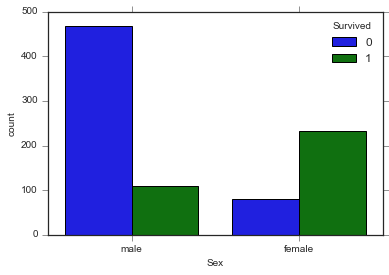

In [3]:
sn.set_style('ticks')
sn.countplot(x='Sex',hue='Survived',data=train)

从上面的图很明显看到女性（female）的生存概率比男性（male）大多了。那性别肯定是一个相关因素。

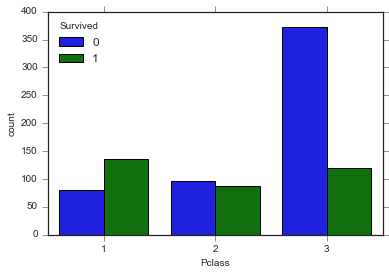

In [4]:
sn.countplot(x='Pclass', hue='Survived', data=train)

看得出，船舱等级（Pclass）从1到3，获救的比例是逐渐下降的。

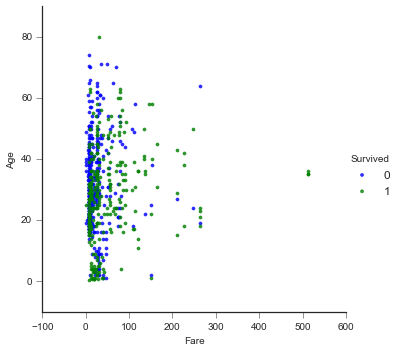

In [5]:
sn.lmplot(x='Fare', y='Age', data=train, hue='Survived', fit_reg=False, scatter_kws={"s": 10})

从年龄上，可以看到在40岁后，获救的概率比较大。20岁以下就难看出有什么规律了。从散点图上也很难看出票价（Fare）和获救的关系。

In [17]:
ticket = train['Ticket']
print "Groups: ", len(set(ticket))
print "Total Num: ", len(ticket)

Groups:  681
Total Num:  891


票码（Ticket）是一类字符串格式的数据格式，初步统计了下Ticket这列有681个不同的值，可以看成是681个不同的类别，其中一共有891个值，差不多每个值都单独成一组。利用`sklearn.preprocessing`中的`LabelEncoder`和`OneHotEncoder`，把这些标签进行转换，转换为稀疏矩阵，行列为891 X 681。

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
ticket_array = np.array(ticket)
label_encoder = LabelEncoder()
ticket_integer = label_encoder.fit_transform(ticket_array)
ticket_integer = ticket_integer.reshape(len(ticket_integer),1)
ticket_onehot_encoder = OneHotEncoder(sparse=False)
ticket_encoded = ticket_onehot_encoder.fit_transform(ticket_integer)
print ticket_encoded.shape

(891, 681)


对于这种文字类型的数据格式可以按照上面的方法进行转换，最后生成一系列的数据矩阵。

## 3.利用决策树来预测生存率
我们首先尝试利用一个因素，那就是性别（Sex）来进行预测。需要提前将性别里面的female和male进行数据转换。

In [19]:
sex_encoder = label_encoder.fit_transform(train['Sex'])
sex = sex_encoder.reshape(len(sex_encoder),1)
sex_onehot = ticket_onehot_encoder.fit_transform(sex)
print 'Transform1\n',sex[1:5,]
print 'Transform2\n',sex_onehot[1:5,]
# 这里进行了两种转换，一种是简单的利用0和1来表示female和male，另一种是用[1,0]和[0,1]来分别表示，想看看这两个方法的预测结果有何不同

Transform1
[[0]
 [0]
 [0]
 [1]]
Transform2
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]


In [20]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier(random_state=0)
print sex.shape
clf.fit(X=sex, y=train['Survived'])

(891, 1)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

使用**KFold**交叉验证法进行评估模型的预测效果

In [21]:
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, sex, train['Survived'], cv=10)
print "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Accuracy: 0.79 (+/- 0.06)


In [22]:
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, sex_onehot, train['Survived'], cv=10)
print "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Accuracy: 0.79 (+/- 0.06)


上面的结果上看，用0，1表示性别还是用[0,1]这种表示性别，几乎没有差别。准确率是0.79。那如果我们加入船舱等级（Pclass）这个因素呢？

In [59]:
clf = DecisionTreeClassifier(random_state=0)
X = pd.DataFrame({'Pclass':train['Pclass'], 'Sex':sex[:,0]})
Pclass = train['Pclass'].reshape(891,1)
scores = cross_val_score(clf, X, train['Survived'], cv=10)
print "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Accuracy: 0.77 (+/- 0.06)


In [73]:
from sklearn.preprocessing import Imputer
Age = train['Age']
imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
imp.fit(Age)
Age = imp.transform(Age)
clf = DecisionTreeClassifier(random_state=0)
print Age.shape, sex.shape
X = pd.DataFrame({'Age':Age[0,:], 'Sex':sex[:,0], 'Pclass':train['Pclass'],'Fare':train['Fare']})
scores = cross_val_score(clf, X, train['Survived'], cv=10)
print "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

(1, 891) (891, 1)
Accuracy: 0.78 (+/- 0.08)


/nfs3/onegene/user/group1/linxingzhong/workspace/bio2.7.10/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [69]:
import numpy as np
from sklearn.preprocessing import Imputer
X = [[np.nan, 2], [6, np.nan], [7, 6]]
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
#imp.fit([[1, 2], [np.nan, 3], [7, 6]])


print(imp.transform(X))     
print train['Age'].mean()
print len(train['Age'])

[[ 6.5  2. ]
 [ 6.   4. ]
 [ 7.   6. ]]
29.6991176471
891
